In [10]:
#アンサンブル関数 MajorityVoteClassifier
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [11]:
#データ読み込み
from sklearn import datasets
import pandas as pd
df = pd.read_csv('isigaki_miyako_iriomote_wavedata/isigaki_test.csv', header=None)

import numpy as np
from sklearn.preprocessing import LabelEncoder
#データのロード
X = df.loc[:, [1,4]].values
#print(X)
y = df.loc[:, 0].values

In [12]:
#データの分割（テスト用とトレーニング用）
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)
print('Labels counts in y[0 1]:', np.bincount(y))
print('Labels counts in y_train[0 1]:', np.bincount(y_train))
print('Labels counts in y_test[0 1]:', np.bincount(y_test))
print(X_train)
print(y_train)

Labels counts in y[0 1]: [4723   25]
Labels counts in y_train[0 1]: [3778   20]
Labels counts in y_test[0 1]: [945   5]
[[ 3.7  10.  ]
 [ 3.1  14.  ]
 [ 4.2  10.5 ]
 ...
 [ 4.1   1.65]
 [ 6.4   1.2 ]
 [ 4.5   8.5 ]]
[0 0 0 ... 0 0 0]


In [13]:
#各分類機での10分割交差検証
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

clf1 = LogisticRegression(penalty='l2', 
                          C=10,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.5f (+/- %0.5f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 1.00000 (+/- 0.00000) [Logistic regression]
ROC AUC: 1.00000 (+/- 0.00000) [Decision tree]
ROC AUC: 0.99987 (+/- 0.00040) [KNN]


In [14]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.5f (+/- %0.5f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 1.00000 (+/- 0.00000) [Logistic regression]
ROC AUC: 1.00000 (+/- 0.00000) [Decision tree]
ROC AUC: 0.99987 (+/- 0.00040) [KNN]
ROC AUC: 1.00000 (+/- 0.00000) [Majority voting]


In [15]:
#モデルの保存
import pickle
import os
dest = os.path.join('classifier','pkl-objects')#パスの結合
if not os.path.exists(dest):
    os.makedirs(dest)
pickle.dump(mv_clf,
            open(os.path.join(dest,'ensemble.pkl'),
            'wb'))#'classifier/pkl-objects/ensemble.pklで保存)


In [16]:
#ROC曲線
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('images/07_04', dpi=300)
plt.show()

In [17]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

/Users/e175755/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


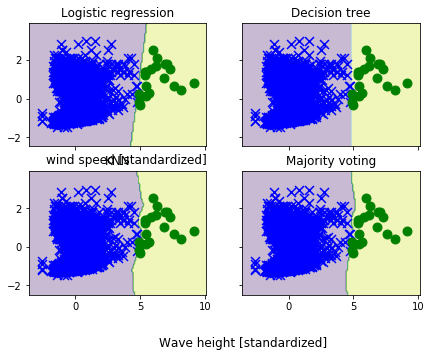

In [18]:
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='x',
                                  s=80)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=80)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Wave height [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='wind speed [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=0)

#plt.savefig('images/07_05', dpi=300)
plt.show()
#predict = mv_clf.predict(X_train_std)
#print(predict)

In [19]:
#グラフをプロットするための関数
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

[[19.1   8.8 ]
 [16.4   7.05]
 [15.3   5.95]
 [ 2.2   1.7 ]
 [ 5.1   2.35]
 [14.1   6.2 ]]
データのクラス
[1 1 1 0 0 0]
mv_clfモデルによるデータのクラス予想
[1 1 1 0 0 0]
データそれぞれに対するクラス[0 1]の所属解率
[[5.01451134e-03 9.94985489e-01]
 [6.56950521e-02 9.34304948e-01]
 [1.40006347e-01 8.59993653e-01]
 [9.99999623e-01 3.76743304e-07]
 [9.99991297e-01 8.70316804e-06]
 [9.13136695e-01 8.68633051e-02]]


/Users/e175755/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/e175755/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


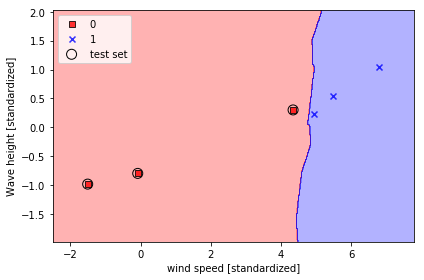

In [20]:
df1 = pd.read_csv('isigaki_miyako_iriomote_wavedata/test_1.csv', header=None)
X1 = df1.loc[:, [1,4]].values
#print(X)
y1 = df1.loc[:, 0].values
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.02, random_state=0)
print(X1)
"""
#mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='x',
                                  s=80)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=80)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Wave height [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='wind speed [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=0)

#plt.savefig('images/07_05', dpi=300)
plt.show()
"""

X1_train_std = sc.transform(X1)
#X1_train_pca = pca.fit_transform(X1_train_std)
predict = mv_clf.predict(X1_train_std)
predict_proba = mv_clf.predict_proba(X1_train_std)

#データに対する予測確率
print('データのクラス')
print(y1)
print('mv_clfモデルによるデータのクラス予想')
print(predict)
print('データそれぞれに対するクラス[0 1]の所属解率')
print(predict_proba)

plt.figure(1)
#plot_data(X1_train_std, y1)


plot_decision_regions(X=X1_train_std, y=y1,
                      classifier=mv_clf, test_idx=range(3, 6))#test_idx=range(105, 150)はテストデータの開始行数から終了行数まで
plt.xlabel('wind speed [standardized]')
plt.ylabel('Wave height [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()


#mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
    

/Users/e175755/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


explained variance ratio (first two components): [0.92461621 0.05301557] 


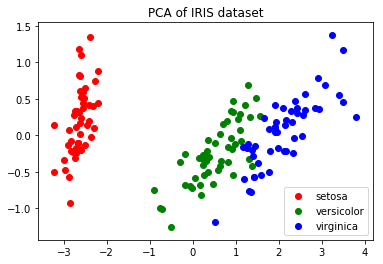

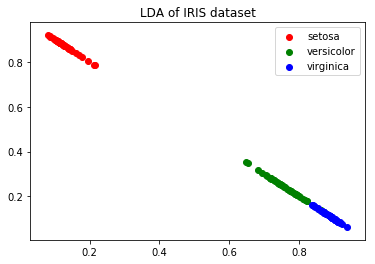

[[-2.68420713  0.32660731]
 [-2.71539062 -0.16955685]
 [-2.88981954 -0.13734561]
 [-2.7464372  -0.31112432]
 [-2.72859298  0.33392456]
 [-2.27989736  0.74778271]
 [-2.82089068 -0.08210451]
 [-2.62648199  0.17040535]
 [-2.88795857 -0.57079803]
 [-2.67384469 -0.1066917 ]
 [-2.50652679  0.65193501]
 [-2.61314272  0.02152063]
 [-2.78743398 -0.22774019]
 [-3.22520045 -0.50327991]
 [-2.64354322  1.1861949 ]
 [-2.38386932  1.34475434]
 [-2.6225262   0.81808967]
 [-2.64832273  0.31913667]
 [-2.19907796  0.87924409]
 [-2.58734619  0.52047364]
 [-2.3105317   0.39786782]
 [-2.54323491  0.44003175]
 [-3.21585769  0.14161557]
 [-2.30312854  0.10552268]
 [-2.35617109 -0.03120959]
 [-2.50791723 -0.13905634]
 [-2.469056    0.13788731]
 [-2.56239095  0.37468456]
 [-2.63982127  0.31929007]
 [-2.63284791 -0.19007583]
 [-2.58846205 -0.19739308]
 [-2.41007734  0.41808001]
 [-2.64763667  0.81998263]
 [-2.59715948  1.10002193]
 [-2.67384469 -0.1066917 ]
 [-2.86699985  0.0771931 ]
 [-2.62522846  0.60680001]
 

In [21]:
print ( __doc__ )

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
#from sklearn.lda import LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

iris = datasets .  load_iris ()
sc = StandardScaler()
X = sc.fit_transform(X)
X = iris .  data
y = iris .  target
target_names = iris .  target_names

pca = PCA ( n_components = 2 )
X_r = pca .  fit ( X ) .  transform ( X )

lda = LDA ( n_components = 2 )
X_r2 = lda .  fit ( X , y ) .  transform ( X )

# Percentage of variance explained for each components
print ( 'explained variance ratio (first two components): %s '
      % str ( pca . explained_variance_ratio_ ))

plt .  figure ()
for c , i , target_name in zip ( "rgb" , [ 0 , 1 , 2 ], target_names ):
     plt .  scatter ( X_r [ y == i , 0 ], X_r [ y == i , 1 ], c = c , label = target_name )
plt .  legend ()
plt .  title ( 'PCA of IRIS dataset' )

plt .  figure ()
for c , i , target_name in zip ( "rgb" , [ 0 , 1 , 2 ], target_names ):
     plt .  scatter ( X_r2 [ y == i , 0 ], X_r2 [ y == i , 1 ], c = c , label = target_name )
plt .  legend ()
plt .  title ( 'LDA of IRIS dataset' )

plt .  show ()
print(X_r)
print(X_r2)